In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import all required libraries and modules

In [110]:
import os 
import sys
import optuna
import logging
import numpy as np 
import pandas as pd 
import seaborn as sns
from typing import Union
import plotly.express as px
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [111]:
# sys.path.append('/home/nikolay/Deloitte/project_task/Iris/')
# os.chdir('/home/nikolay/Deloitte/project_task/Iris')
os.chdir("/Users/nikolaynechay/Iris-Species")

sns.set(style='white', color_codes=True)

load_dotenv()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from src.core.helpers.plot_target_distribution import plot_target_distribution
from src.core.helpers.visualize_distribution import visualize_distribution
from src.core.helpers.calculate_boundaries import boundaries
from src.core.helpers.vit import calculate_vif 
from src.core.helpers.delete_outliers import delete_outliers
from src.core.helpers.statistics_distribution_to_target import statistics_distribution_to_target
from src.core.helpers.plot_histograms import plot_histograms
from src.core.helpers.scatter_plot import scatter_plot
from src.core.helpers.optuna_objective import objective_for_logistic_regression
from src.core.helpers.optuna_objective import objective_for_xgboost_classifier
from src.core.helpers.confusion_matrix import plot_confusion_matrix
from src.core.helpers.features_generator import add_petal_ratio_feature, add_sepal_area_feature, add_petal_area_feature

##### Define global variables

In [112]:
IRIS_PATH="src/core/datafiles/raw/Iris.csv"

##### Load dataset and check first five rows of them

In [113]:
iris_df = pd.read_csv(IRIS_PATH)
iris_df.drop('Id', axis=1, inplace=True)  # Delete ID column
display(iris_df.head().style.background_gradient(cmap='Greys'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


##### Check Missing Values

In [114]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Observations :
    
* After displaying info, we can see that there are no missing values in this dataset and all features are numerical and target variable is categorical. 

In [115]:
iris_df.shape

(150, 5)

Observations:
* There are 150 samples in the dataset and 5 features.

##### Basic Statistics

Display some basic statistics like: (mean, standard deviation, minimum, maximum, 25th percentile, 50th percentile and 75 percentile of distribution by each feature)

In [116]:
iris_df.describe().T.style.background_gradient(cmap='Greys')

,count,mean,std,min,25%,50%,75%,max
SepalLengthCm,150.000000,5.843333,0.828066,4.300000,5.100000,5.800000,6.400000,7.900000
SepalWidthCm,150.000000,3.054000,0.433594,2.000000,2.800000,3.000000,3.300000,4.400000
PetalLengthCm,150.000000,3.758667,1.764420,1.000000,1.600000,4.350000,5.100000,6.900000
PetalWidthCm,150.000000,1.198667,0.763161,0.100000,0.300000,1.300000,1.800000,2.500000


Observations:

* The Sepal Length ranges from [4.3 - 7.9] with a mean of [5.8433] cm and standard deviation 0.82 cm.
* The Sepal Width ranges from [2.0 - 4.4] with a mean of [3.0540] cm and standard deviation 0.43 cm.
* The Petal Length ranges from [1.0 - 6.9] with a mean of [3.758] cm and standard deviation 1.76 cm.
* The Petal Width ranges from [0.1 - 2.5] with a mean of [1.198667] cm and standard deviation 0.76 cm.


In [117]:
numeric_iris_df = iris_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_iris_df.corr()
correlation_matrix.style.background_gradient(cmap='Greys')

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


Below is the correlation matrix that shows the pairwise linear correlations between four features of the Iris dataset: SepalLengthCm, SepalWidthCm, PetalLengthCm, and PetalWidthCm.This matrix is critical for understanding how strongly these features are related to each other. A correlation value ranges from -1 to 1, where:

* 1 indicates a perfect positive correlation,

* -1 indicates a perfect negative correlation,

* 0 indicates no correlation.

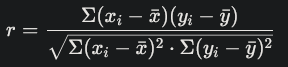

r - coefficient of correlation Pearson

This coefficient measures the strength and direction of the linear correlation between two random variables

Based on this correlation matrix, i can see that next pairs of features have significant positive correlation:
* (PetalLengthCm, SepalLengthCm) == 0.879374
* (SepalLengthCm, PetalWidthCm) == 0.822577
* (PetalLengthCm, PetalWidthCm) == 0.961755 (This 2 features have over 95% of correlation, thats why i will calculate VIF(Variance Inflation Factor)
to check this features on multicollinearity)

Next pairs of features have significant negative correlation:
* (SepalWidthCm, PetalLengthCm) == -0.397123
* (SepalWidthCm, PetalWidthCm) == -0.329782


Based on the analysis of the VIF values, we can conclude that if two features exhibit high multicollinearity (i.e., VIF values is equal to 13.3), one of them can be safely removed from the model. High VIF indicates that the information from one feature is already captured by another, making it redundant. Removing such features helps reduce multicollinearity, improving the stability and interpretability of the model. Therefore, based on the VIF results, we can confidently decide to eliminate one of the highly correlated features to enhance model performance.


In [118]:
calculate_vif(iris_df, 'PetalLengthCm', 'PetalWidthCm', 5, 1)
calculate_vif(iris_df, 'PetalLengthCm', 'SepalLengthCm', 5, 1)
calculate_vif(iris_df, 'SepalLengthCm', 'PetalWidthCm', 5, 1)
calculate_vif(iris_df, 'SepalWidthCm', 'PetalLengthCm', 5, 1)
calculate_vif(iris_df, 'SepalWidthCm', 'PetalWidthCm', 5, 1)

# iris_df.drop(['PetalLengthCm'], axis=1, inplace=True)

INFO:src.core.helpers.vit:High multicollinearity between PetalLengthCm and PetalWidthCm value: 13.680120357329685
INFO:src.core.helpers.vit:Normal multicollinearity between PetalLengthCm and SepalLengthCm value: 4.165890956564887
INFO:src.core.helpers.vit:Normal multicollinearity between SepalLengthCm and PetalWidthCm value: 3.0215875479967123
INFO:src.core.helpers.vit:Normal multicollinearity between SepalWidthCm and PetalLengthCm value: 1.2148214839375164
INFO:src.core.helpers.vit:Normal multicollinearity between SepalWidthCm and PetalWidthCm value: 1.1456376877999441


If we examine the distribution of the target variable, we can observe that it is uniformly distributed.

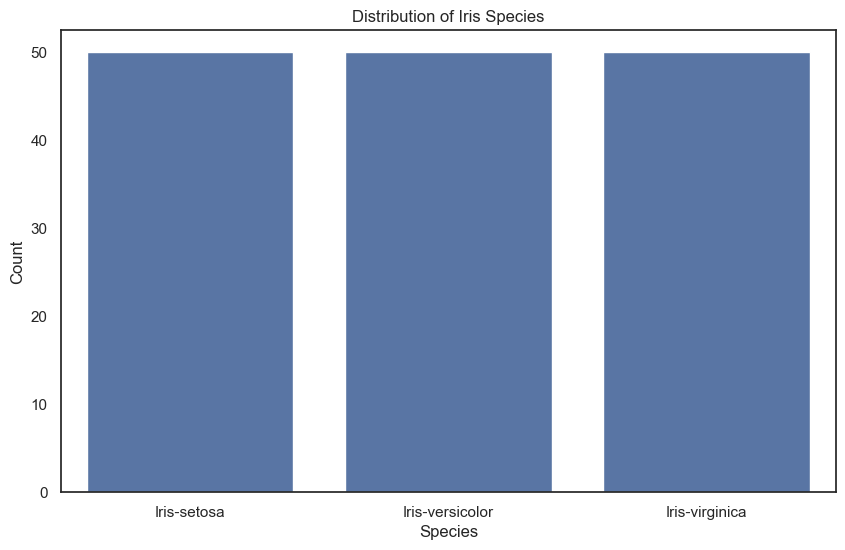

In [119]:
plot_target_distribution(iris_df)

##### Check and delete duplicate data

In [120]:
print(f"Number of duplicates in data: {iris_df.duplicated().sum()}")
iris_df.drop_duplicates(inplace=True)
print(f"Number of duplicates in data: {iris_df.duplicated().sum()}")

Number of duplicates in data: 3
Number of duplicates in data: 0


# EDA

### Uni-Variate Analysis

Univariate analysis is a statistical method used to analyze a single variable at a time. It focuses on understanding the characteristics and distribution of a single variable, such as its central tendency, dispersion, and shape of the distribution.
After analyzing the distribution of each feature, it becomes clear that there are practically no outliers in the data, with the exception of a few samples where the feature `Sepal Width` exceeds the acceptable boundaries. Therefore, I will conduct a statistical test to determine this outliers in the data and remove them.

##### Check Outliers and delete 

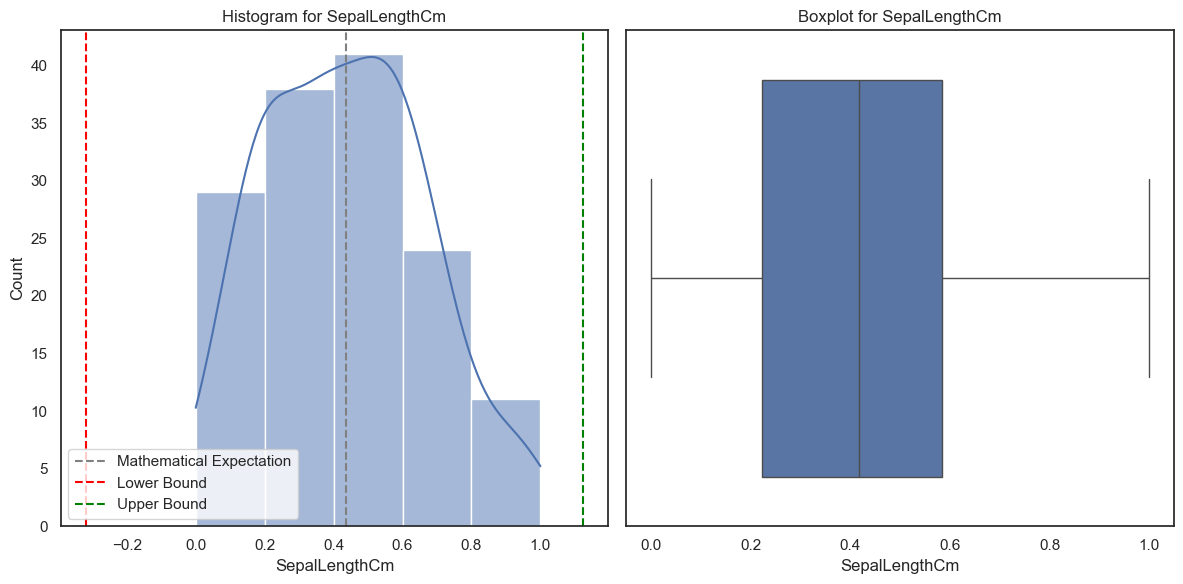

Number of outliers in SepalLengthCm: 0


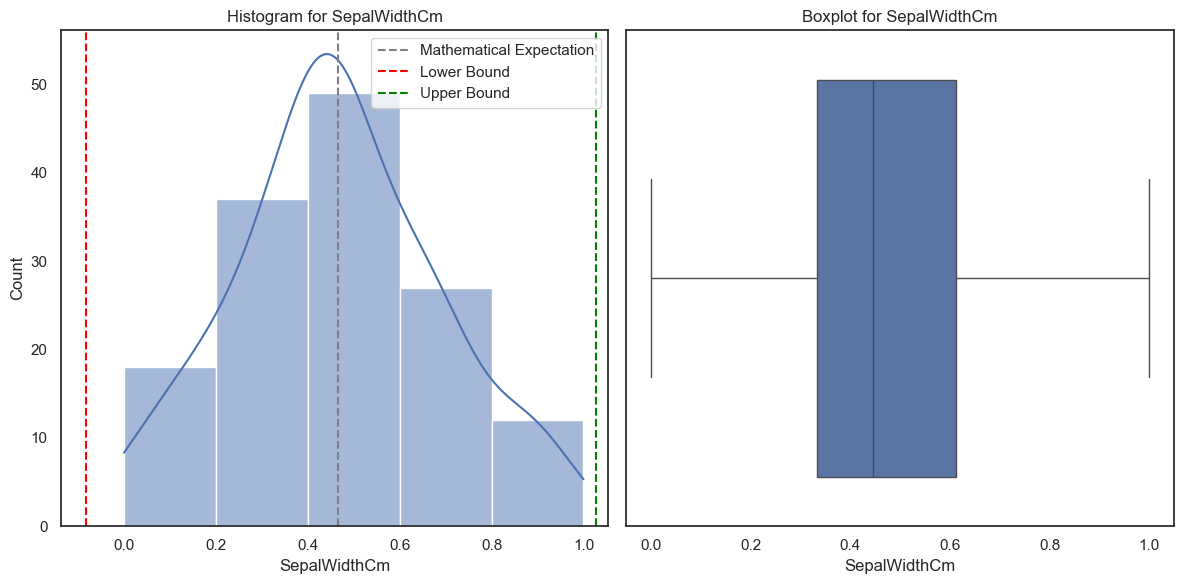

Number of outliers in SepalWidthCm: 0


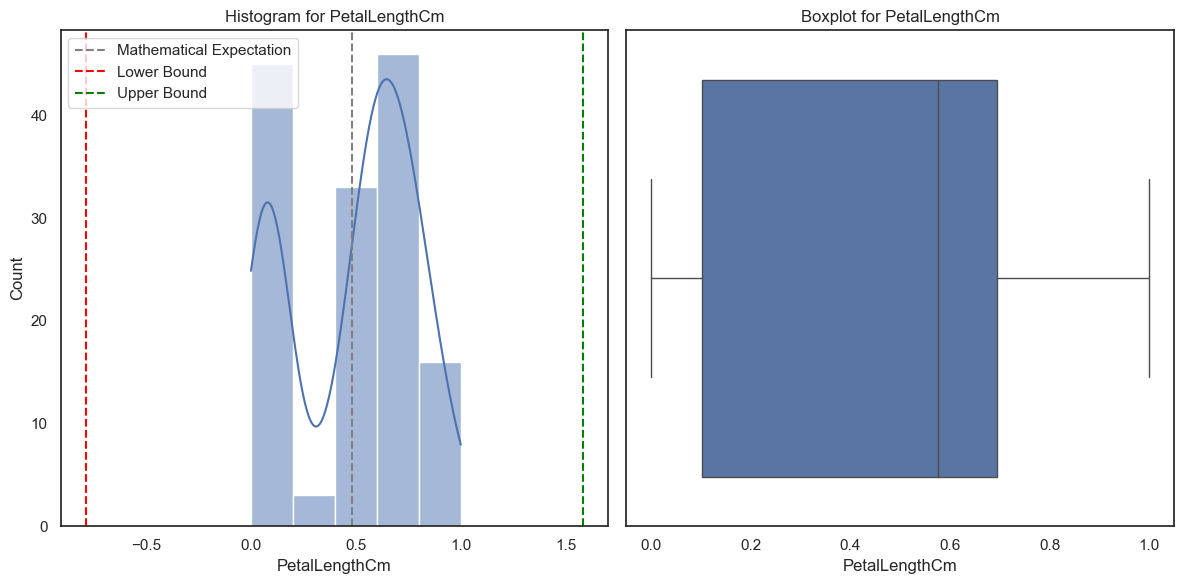

Number of outliers in PetalLengthCm: 0


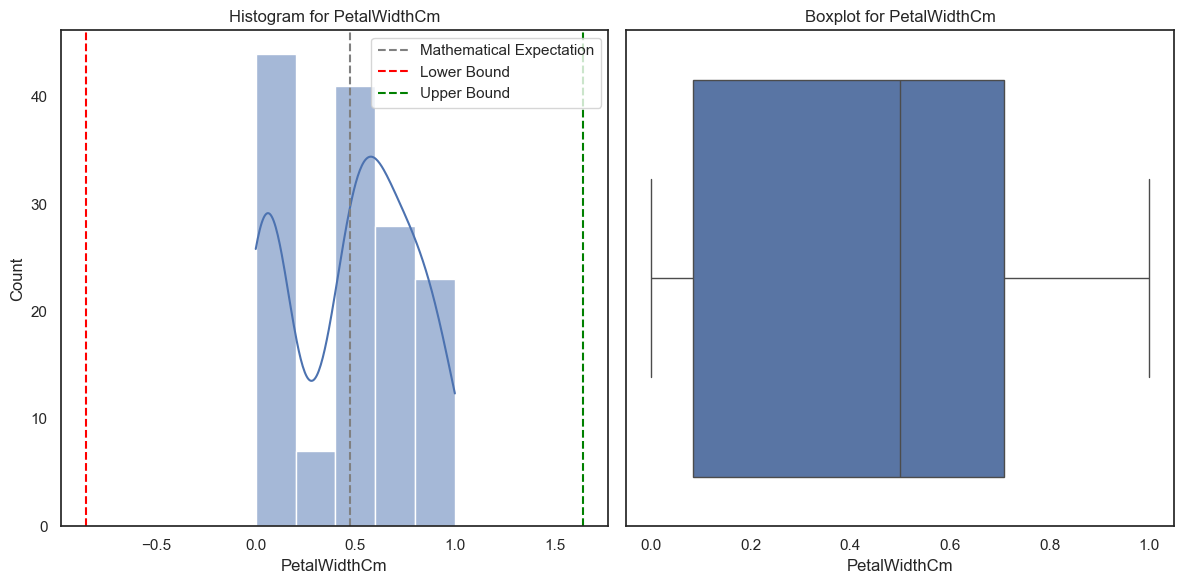

Number of outliers in PetalWidthCm: 0


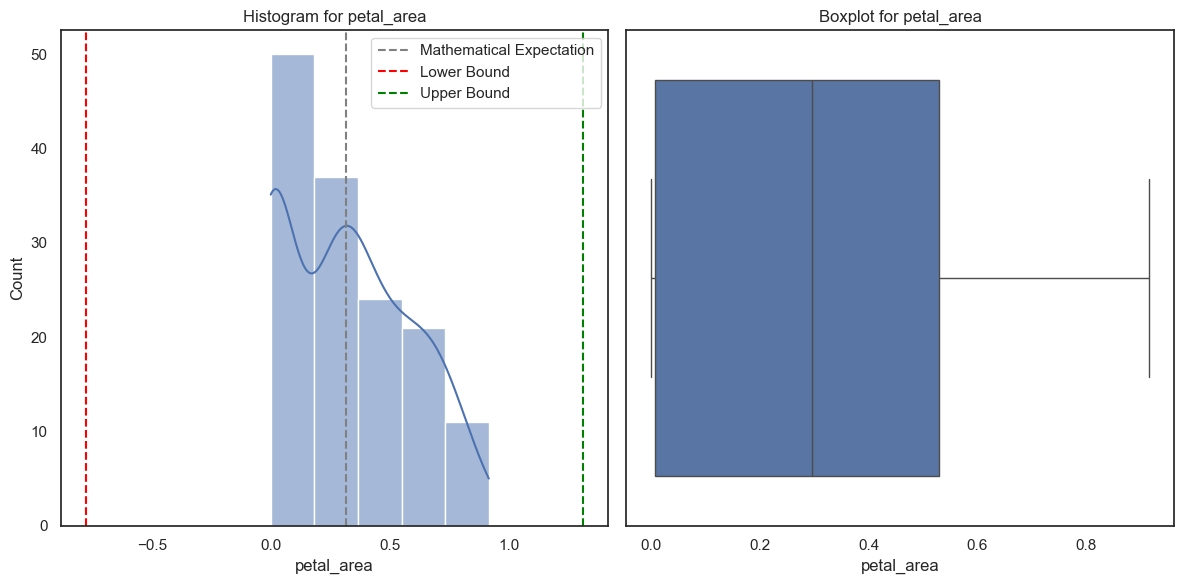

Number of outliers in petal_area: 0


/Users/nikolaynechay/Iris-Species/src/core/helpers/visualize_distribution.py:19: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/Users/nikolaynechay/anaconda3/envs/deloitte_studing_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



KeyboardInterrupt: 

In [141]:
for feature in df_with_new_features.columns[:-1]:
    lower_bound, upper_bound = boundaries(df_with_new_features[feature])
    if lower_bound is not None and upper_bound is not None:
        visualize_distribution(df_with_new_features[feature], lower_bound, upper_bound)
        df_with_new_features = delete_outliers(df_with_new_features, feature, lower_bound, upper_bound)

In [122]:
iris_df.shape

(143, 5)

In [123]:
display(iris_df.head().style.background_gradient(cmap='Grays'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


### Bivariate Analysis

The goal of this analysis is to identify statistically significant relationships between the target variable and the predictors, as well as between the predictors themselves, in order to understand their joint influence on the model.
Study the differences in numerical features (sepal/petal length and width) between iris species (setosa, versicolor, virginica).

Example:    
- Determine if there are statistically significant differences in the average petal length between the three iris species.

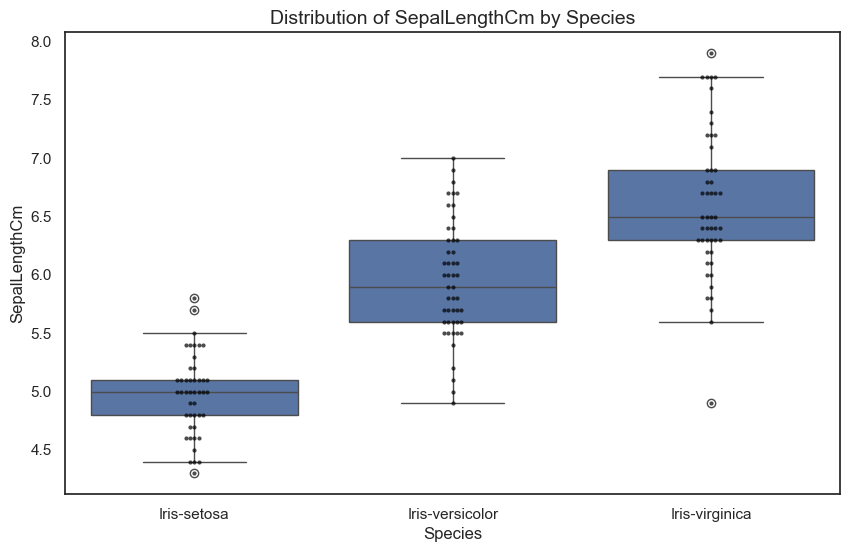

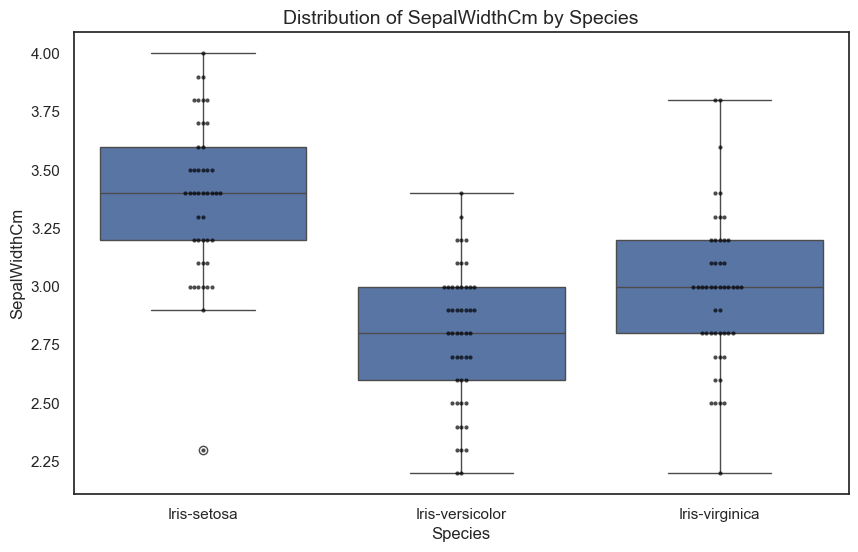

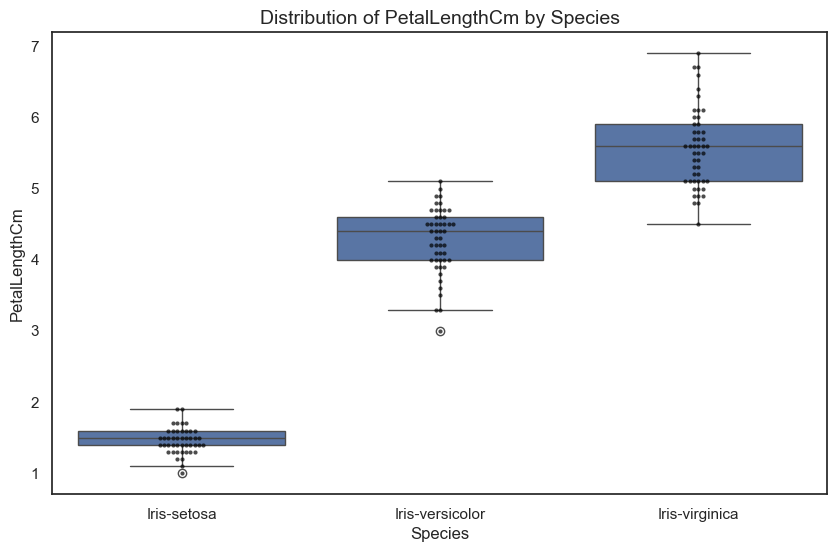

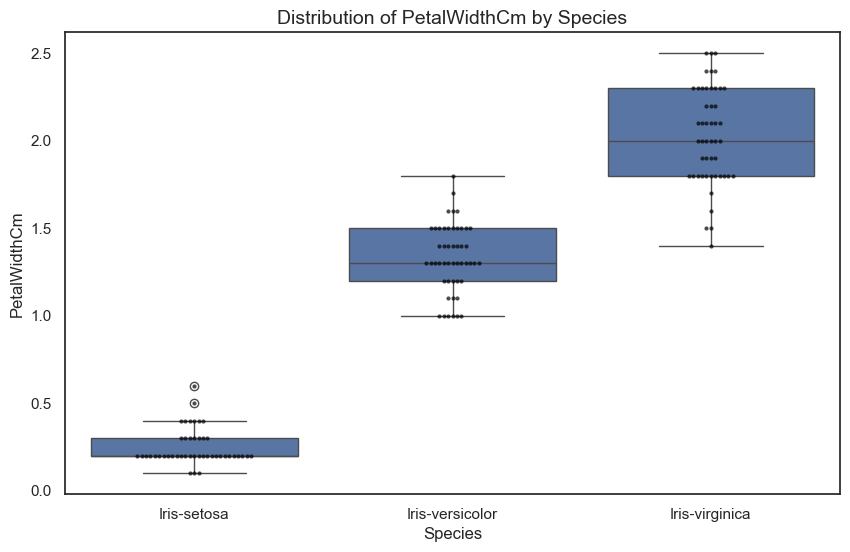

In [124]:
for feature in iris_df.columns[:-1]:
    statistics_distribution_to_target(iris_df, feature)

Analyzing the boxplots for all three features and the three target classes, we can observe that their mean values differ, but the data is not linearly separable, as the \[0.25-0.75] intervals may overlap between classes. However, the *PetalWidth* feature for the Iris-setosa class is clearly linearly separable, meaning we can use this feature to explicitly classify this class.

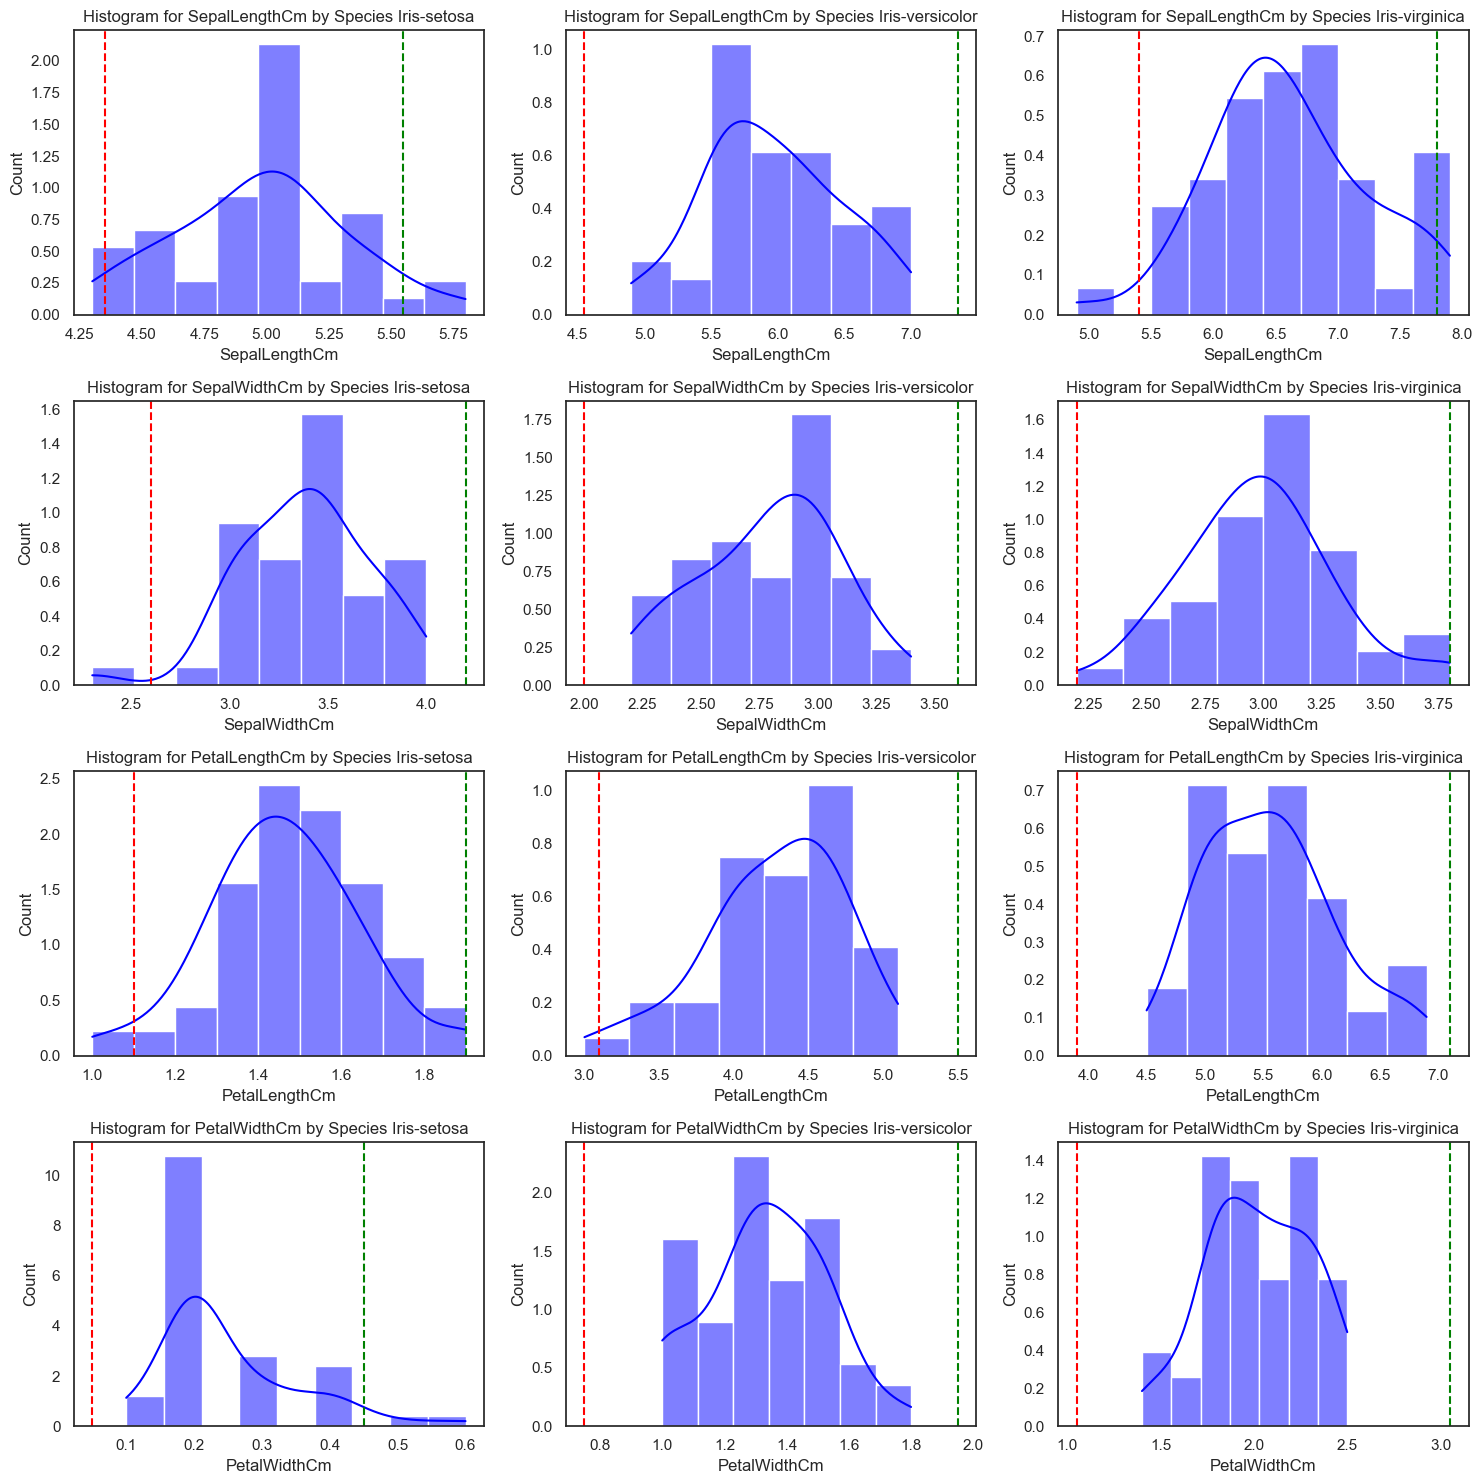

In [125]:
statistics = plot_histograms(iris_df)

In [126]:
statistics[:]

,count,mean,std,min,25%,50%,75%,max,pair
0,45.0,4.980000,0.346148,4.3,4.8,5.0,5.1,5.8,Iris-setosa_SepalLengthCm
1,49.0,5.955102,0.503348,4.9,5.6,5.9,6.3,7.0,Iris-versicolor_SepalLengthCm
2,49.0,6.604082,0.632113,4.9,6.3,6.5,6.9,7.9,Iris-virginica_SepalLengthCm
3,45.0,3.377778,0.330213,2.3,3.2,3.4,3.6,4.0,Iris-setosa_SepalWidthCm
4,49.0,2.785714,0.296507,2.2,2.6,2.8,3.0,3.4,Iris-versicolor_SepalWidthCm
5,49.0,2.979592,0.323380,2.2,2.8,3.0,3.2,3.8,Iris-virginica_SepalWidthCm
6,45.0,1.462222,0.182519,1.0,1.4,1.5,1.6,1.9,Iris-setosa_PetalLengthCm
7,49.0,4.275510,0.461668,3.0,4.0,4.4,4.6,5.1,Iris-versicolor_PetalLengthCm
8,49.0,5.561224,0.553706,4.5,5.1,5.6,5.9,6.9,Iris-virginica_PetalLengthCm
9,45.0,0.251111,0.103621,0.1,0.2,0.2,0.3,0.6,Iris-setosa_PetalWidthCm


Observations:
- There's a clear increasing trend in mean sepal length across the three species, with Iris-setosa having the smallest mean sepal length, followed by Iris-versicolor, and finally Iris-virginica with the largest mean.
- Standard deviation increases from Iris-setosa to Iris-virginica, indicating that Iris-virginica's sepal length values are more spread out than those of the other species.
- Iris-setosa has the largest mean sepal width, while Iris-versicolor has the smallest. This difference in width could be useful in distinguishing Iris-setosa from the other two species.
- The standard deviations are quite similar across all species, suggesting that the variation in sepal width is relatively consistent
- The PetalWidth feature clearly shows the most significant variation between the species. Iris-setosa has a much smaller petal width than both Iris-versicolor and Iris-virginica.
- Iris-virginica has the largest mean and spread in petal width, while Iris-versicolor is intermediate.
- Iris-setosa's petal width appears to be completely separable, which could be a key feature for classification.

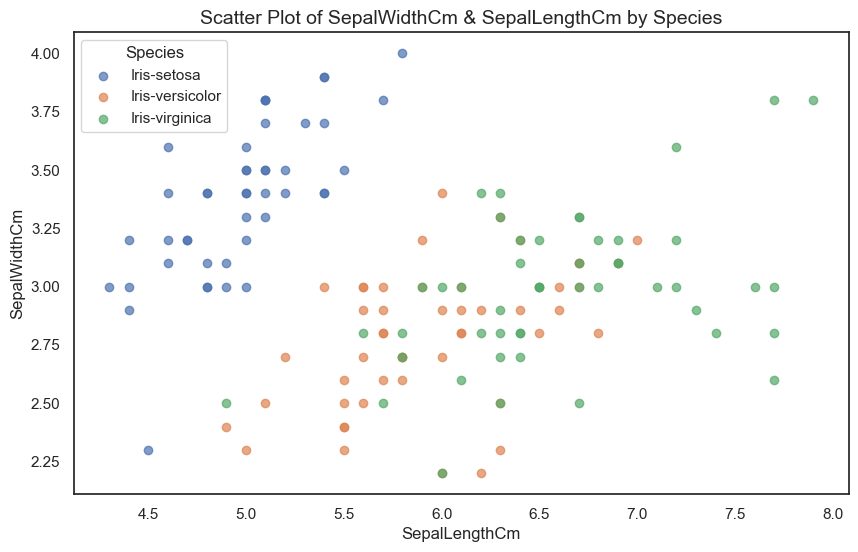

In [127]:
scatter_plot(iris_df, 'SepalLengthCm', 'SepalWidthCm')

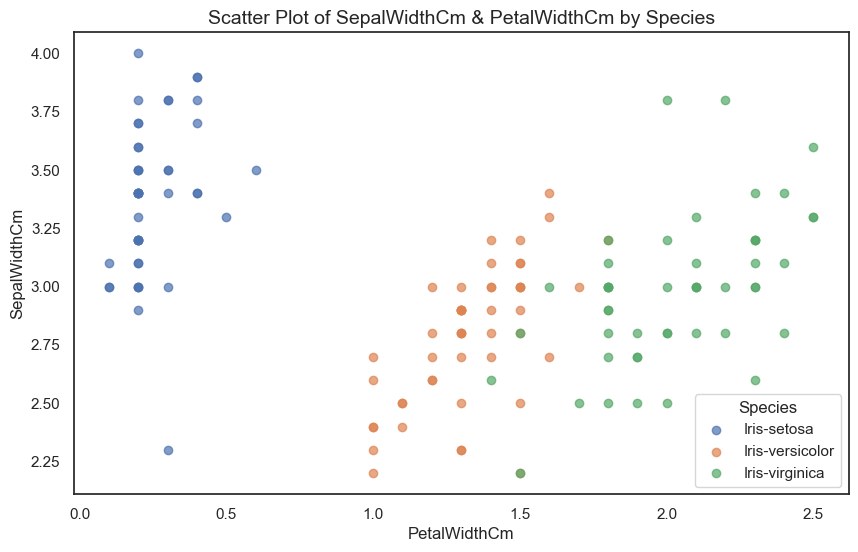

In [128]:
scatter_plot(iris_df, 'PetalWidthCm', 'SepalWidthCm')

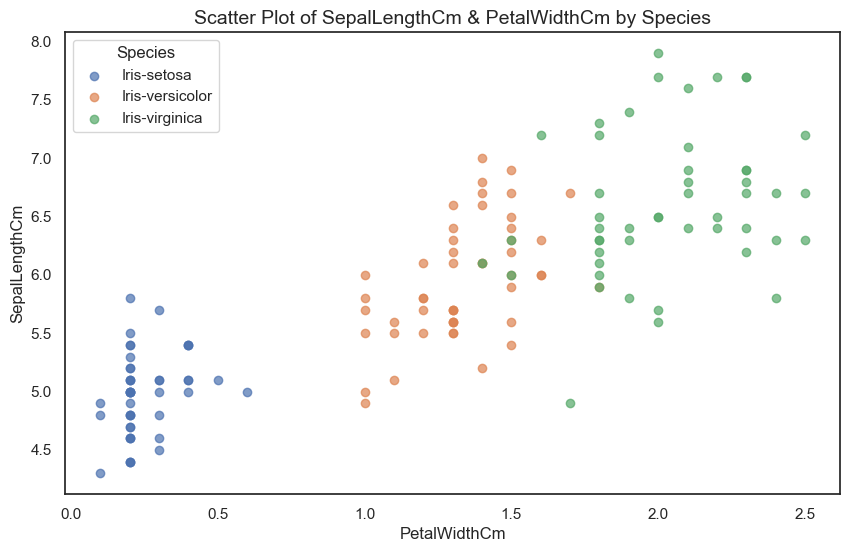

In [129]:
scatter_plot(iris_df, 'PetalWidthCm', 'SepalLengthCm')

Observations:

- Iris-setosa:
This iris class is clearly linearly separable, making it easy to distinguish from other species in any two-dimensional feature space. The primary distinguishing rule for Iris-setosa lies in the SepalLengthCm parameter, as the values for this feature are significantly smaller in this class compared to others. Iris-setosa can be classified effectively using simple linear classification methods, such as logistic regression or linear discriminant analysis, as well as shallow decision trees based on decision rules related to the SepalLengthCm value.

- Iris-versicolor:
For Iris-versicolor, the situation is more complex due to significant overlap with Iris-virginica across various features. Linear separation is particularly challenging as many samples of this class are linearly inseparable. However, upon closer inspection, SepalLengthCm emerges as a key feature for separating these species. By utilizing this feature, a separating hyperplane between Iris-versicolor and Iris-virginica can be constructed, but overall, the classification task remains difficult. In this case, more advanced methods, such as ensemble models (e.g., random forests) or gradient boosting methods, should be considered to improve classification performance.

- Iris-virginica:
This species of iris is partially separable from others based on the PetalWidthCm feature, helping to distinguish it from Iris-setosa and Iris-versicolor. However, Iris-virginica overlaps with Iris-versicolor in terms of SepalLengthCm, making classification challenging. To improve the classification accuracy of this species, it is recommended to use nonlinear models, such as Support Vector Machines (SVM) or Boostings, which are capable of capturing more complex decision boundaries between these classes.

In [130]:
fig = px.scatter_3d(iris_df, 
                    x='SepalLengthCm', 
                    y='SepalWidthCm', 
                    z='PetalWidthCm', 
                    color='Species',
                    title='3D Scatter Plot of Iris Species')

# fig.show()

# Feature Engineering

### Variable Transformation (Normalization and Scaling)

In this case, I will use the **normalization** approach, as it is more preferable compared to **standardization**. Standardization requires the data to have a significant number of outliers and to follow a normal distribution. Normalization, on the other hand, is a more versatile technique that works well for most tasks, especially when the data distribution is not normal, and when it is important to work within a fixed range (e.g., from 0 to 1).

In [131]:
scaler = MinMaxScaler()
normalized_iris_df = iris_df.copy()
normalized_iris_df[iris_df.columns[:-1]] = scaler.fit_transform(iris_df[iris_df.columns[:-1]])
display(normalized_iris_df.head().style.background_gradient(cmap='Greys'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,0.222222,0.722222,0.067797,0.041667,Iris-setosa
1,0.166667,0.444444,0.067797,0.041667,Iris-setosa
2,0.111111,0.555556,0.050847,0.041667,Iris-setosa
3,0.083333,0.500000,0.084746,0.041667,Iris-setosa
4,0.194444,0.777778,0.067797,0.041667,Iris-setosa


In [132]:
normalized_iris_df.describe().T.style.background_gradient(cmap='Greys')

,count,mean,std,min,25%,50%,75%,max
SepalLengthCm,143.000000,0.436286,0.231957,0.000000,0.222222,0.416667,0.583333,1.000000
SepalWidthCm,143.000000,0.465812,0.221234,0.000000,0.333333,0.444444,0.611111,1.000000
PetalLengthCm,143.000000,0.479791,0.296750,0.000000,0.101695,0.576271,0.694915,1.000000
PetalWidthCm,143.000000,0.471154,0.314391,0.000000,0.083333,0.500000,0.708333,1.000000


In [133]:
label_encoder = LabelEncoder()
normalized_iris_df['Species'] = label_encoder.fit_transform(normalized_iris_df['Species'])
display(normalized_iris_df.head().style.background_gradient(cmap='Greys'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,0.222222,0.722222,0.067797,0.041667,0
1,0.166667,0.444444,0.067797,0.041667,0
2,0.111111,0.555556,0.050847,0.041667,0
3,0.083333,0.500000,0.084746,0.041667,0
4,0.194444,0.777778,0.067797,0.041667,0


### Generate new nonlinear features

In [139]:
df_with_new_features = normalized_iris_df.copy()
for func in [add_petal_area_feature, add_petal_ratio_feature, add_sepal_area_feature]:
    df_with_new_features = func(df_with_new_features)

display(df_with_new_features.head().style.background_gradient(cmap="Greys"))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,petal_area,petal_ration,sepal_area,Species
0,0.222222,0.722222,0.067797,0.041667,0.002825,1.627080,0.160494,0
1,0.166667,0.444444,0.067797,0.041667,0.002825,1.627080,0.074074,0
2,0.111111,0.555556,0.050847,0.041667,0.002119,1.220310,0.061728,0
3,0.083333,0.500000,0.084746,0.041667,0.003531,2.033849,0.041667,0
4,0.194444,0.777778,0.067797,0.041667,0.002825,1.627080,0.151235,0


In [140]:
df_with_new_features.shape

(143, 8)

# Model Building

### Create Training, Validation and Test Set

In [136]:
train, temp = train_test_split(normalized_iris_df, test_size=0.3, random_state=41, stratify=normalized_iris_df['Species'])
test, val = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['Species'])

X_train, y_train = train.drop('Species', axis=1), train['Species']
X_val, y_val = val.drop('Species', axis=1), val['Species']
X_test, y_test = test.drop('Species', axis=1), test['Species']

print(f'Training set:\t X_train {X_train.shape}, y_train {y_train.shape}')
print(f'Validation set:\t X_val {X_val.shape}, y_val {y_val.shape}')
print(f'Test set:\t X_test {X_test.shape}, y_test {y_test.shape}')

Training set:	 X_train (100, 4), y_train (100,)
Validation set:	 X_val (22, 4), y_val (22,)
Test set:	 X_test (21, 4), y_test (21,)


### Train Logistic Regression Model

In [137]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_for_logistic_regression(trial, X_train, y_train, X_val, y_val), n_trials=50)

best_params = study.best_params
print(f'Best Hyperparameters: {best_params}')

best_model = LogisticRegression(**best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")


[I 2025-06-24 12:21:42,240] A new study created in memory with name: no-name-92f96f27-7247-43d6-bb39-dd456a5884ee
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:28: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/Users/nikolaynechay/anaconda3/envs/deloitte_studing_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning:

Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.

[I 2025-06-24 12:21:42,263] Trial 0 finished with value: 0.8060606060606061 and parameters: {'C': 0.5605575211476322, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 785, 'solver': 'liblinear'}.

Best Hyperparameters: {'C': 70.58502003658303, 'penalty': 'l1', 'class_weight': 'balanced', 'max_iter': 974, 'solver': 'liblinear'}
Accuracy: 0.9524
Precision: 0.9583
Recall: 0.9524
F1 Score: 0.9521


### Train XGBoostClassifier Model

In [138]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_for_xgboost_classifier(trial, X_train, y_train, X_val, y_val), n_trials=50)

best_params = study.best_params
print(f'The best params: {best_params}')

best_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

[I 2025-06-24 12:21:42,955] A new study created in memory with name: no-name-ebebb927-380c-4605-b670-2af3b6a04570
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:68: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:69: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:70: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:71: F

KeyboardInterrupt: 

##### Display the first 10 pairs of true and predicted labels by XGBoostClassifier

In [ ]:
# # build a dummy classifier
# model = DummyClassifier(strategy="most_frequent")
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# # Evaluate model
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
# print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
# print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
# print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

In [ ]:
resulted_df = pd.DataFrame({
    'True label': y_test.values,
    'Predicted label': y_pred,
})
display(resulted_df.head(10))

,True label,Predicted label
0,1,1
1,1,1
2,0,0
3,0,0
4,0,0
5,2,1
6,2,2
7,1,1
8,0,0
9,2,2


##### Confusion Matrix of XGBoostClassifier

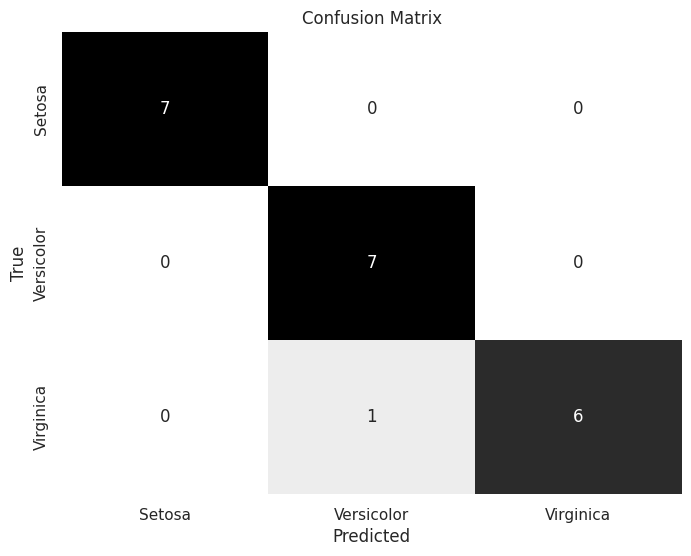

In [ ]:
plot_confusion_matrix(y_test, y_pred)

# Conclusions

During the completion of this classification task on the Iris dataset, a detailed feature analysis was conducted, which revealed a strong linear relationship between the features. However, when attempting to eliminate this dependency, the prediction accuracy decreased, so the decision was made to keep all features. The distribution of the target metric was uniform, and a few outliers were identified and removed during the preprocessing stage. Additionally, no missing values were found in the data.

The data analysis showed that the Iris-setosa class is linearly separable based on two features: PetalWidth and PetalLength, allowing for effective classification. However, the other two classes, Iris-versicolor and Iris-virginica, are not fully linearly separable, making classification more challenging for these species.

After conducting the analysis and preparing the data, three datasets were created: training, validation, and test datasets. All features were normalized and scaled to the range [0, 1].

Two classification models were built: Logistic Regression and XGBoost. Hyperparameter optimization was performed using Optuna, and the F1-score — the harmonic mean of precision and recall — was used as the optimization metric.

At the end of the training, both models produced identical results on quality metrics.

For test dataset:

    Accuracy:  0.9524

    Precision: 0.9583

    Recall:  0.9524

    F1 Score: 0.9521

For val dataset:

    Accuracy: 1

    Precision: 1

    Recall: 1

    F1 Score: 1

Additionally, the confusion matrix was displayed, allowing a detailed evaluation of the models' performance and their classification capabilities.